# Check site layers

```bash
sbatch cluster/processing/marques_vivo/process.sbatch
```

In [8]:
import os
import numpy as np
import spikeinterface as si
import shutil
from matplotlib import pyplot as plt

# set project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

experiment = "vivo_marques"
run = "c26"
data_conf, param_conf = get_config(experiment, run).values()
RAW_RECORDING_PATH = data_conf["raw"]
RECORDING_PATH = data_conf["probe_wiring"]["output"]

2024-01-19 14:29:37,690 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-19 14:29:37,702 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Load already processed

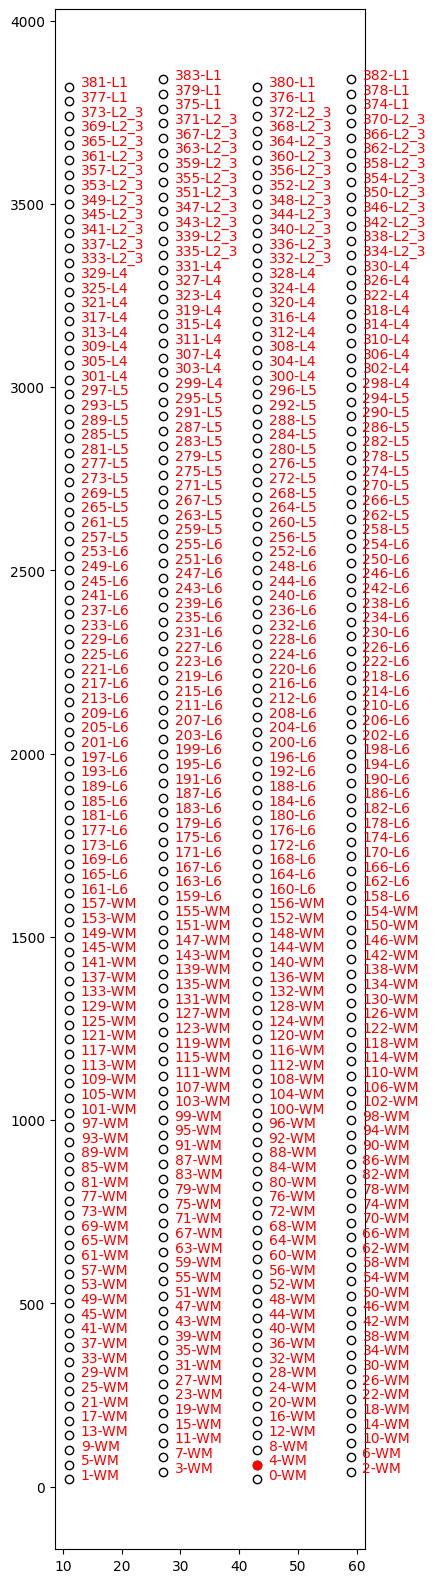

In [12]:
# load Recording with metadata
Recording = si.load_extractor(RECORDING_PATH)
Probe = Recording.get_probe()
site_layers = Recording.get_property("layers")

# plot
contact_coord = Probe.contact_positions
contact_ids = Probe.contact_ids

# plot file contact with ids
fig, ax = plt.subplots(1, 1, figsize=(4, 20))
ax.plot(contact_coord[:, 0], contact_coord[:, 1], "o", markerfacecolor="w", color="k")
for ix in range(len(contact_ids)):
    if ix % 1 == 0:
        ax.text(
            contact_coord[ix, 0] + 2,
            contact_coord[ix, 1],
            "%s" % (str(contact_ids[ix]) + "-" + str(site_layers[ix])),
            size=10,
            zorder=100,
            color="r",
        )
plt.plot(contact_coord[4, 0], contact_coord[4, 1], "ro")

### Or check from scratch

In [9]:
# load probe.wired trace trace
Recording = si.load_extractor(RECORDING_PATH)

# infer layer from site depth
# - flip to get the real depth and site order (with Pial at the top and WM at the bottom) as Marques' sites ids are ordered from the bottom (WM) to the top (Pial)
probe = Recording.get_probe()
site_depth = np.flip(probe.contact_positions[:, 1])  # flip depth (y-axis)

# get layer borders
layer_end = np.array(
    [
        param_conf["layer_border"]["L1"],
        param_conf["layer_border"]["L2_3"],
        param_conf["layer_border"]["L4"],
        param_conf["layer_border"]["L5"],
        param_conf["layer_border"]["L6"],
    ]
)

# set layers borders
layers = ["L1", "L2_3", "L4", "L5", "L6", "WM"]
layer_start = np.hstack([0, layer_end])[:-1]

# find site layers
site_layers = []
for s_i in range(len(site_depth)):
    # for layers
    for l_i in range(len(layer_start)):
        if (site_depth[s_i] >= layer_start[l_i]) and (site_depth[s_i] < layer_end[l_i]):
            site_layers.append(layers[l_i])

    # for white matter
    if site_depth[s_i] >= layer_end[-1]:
        site_layers.append(layers[-1])

# sanity check
assert len(site_layers) == 384, """site count does not match neuropixels'"""

# add metadata to Wired Recording Extractor
Recording.set_property("layers", values=site_layers)

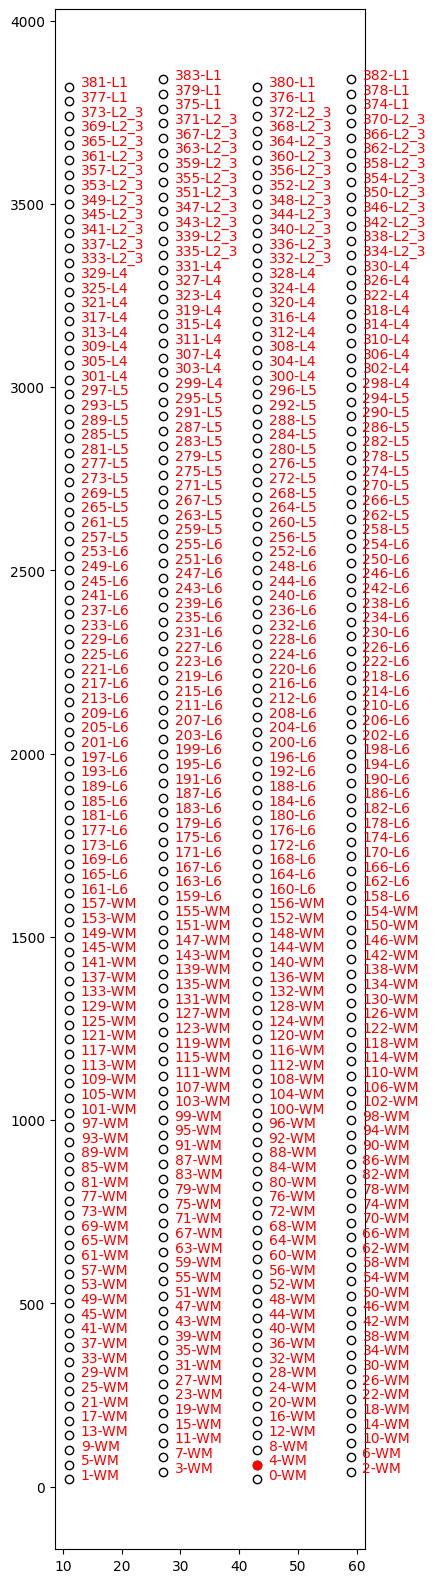

In [10]:
# plot
contact_coord = probe.contact_positions
contact_ids = probe.contact_ids

# plot file contact with ids
fig, ax = plt.subplots(1, 1, figsize=(4, 20))
ax.plot(contact_coord[:, 0], contact_coord[:, 1], "o", markerfacecolor="w", color="k")
for ix in range(len(contact_ids)):
    if ix % 1 == 0:
        ax.text(
            contact_coord[ix, 0] + 2,
            contact_coord[ix, 1],
            "%s" % (str(contact_ids[ix]) + "-" + str(site_layers[ix])),
            size=10,
            zorder=100,
            color="r",
        )
plt.plot(contact_coord[4, 0], contact_coord[4, 1], "ro")